# pycaret을 이용한 가스공급량 예측
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'
* 특성
    * 'month', '시간'으로 기온 예측
    * 기온, 기압, 습도 순서로 예측
    * 각 특성 예측 마다 앞에서 예측한 특성 활용
    * 공급량 예측(7개) : 'month', 'weekday', '시간', '구분', '기온', '기압', '습도'
* 2개 모델('lightgbm', 'catboost') 예측 평균
* 튜닝X, finalize_model X
* 구분별 훈련/예측
* 비율로 계산

## 자체평가
* 비교 대상 sub24_pycaret12.csv(제출 점수 : 0.1032155541)
* 자체점수가 NMAE = 0.69833, R2 = -8.06478 로 낮게 나옴.
    * 원인 : 훈련 특성에 day가 포함 안되어서 같은 요일의 값으로 훈련 되는 문제 발생.
    * 해결 : 훈련 특성에 day를 포함, weekday를 제거

In [1]:
# 제출 파일명 : sub25_pycaret13.csv(제출X)
# 최고점 파일과 비교 점수 : -8.06478 / 0.69833
# 제출 점수 : -

## 데이터 가져오기
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'

In [2]:
from pycaret.regression import *

In [3]:
import time
import datetime
import pandas as pd
from tqdm import tqdm

### 2013-2018년 가스공급량과 기온, 습도, 기압 비율 자료 불러오기

In [4]:
total = pd.read_csv('../2013-2018년_가스공급량_기온_습도_기압_비율.csv')
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


### 2019년 데이터

In [5]:
test2019 = pd.read_csv('../data/test.csv')
test2019.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [6]:
test2019[['연월일', '시간', '구분']] = test2019['일자|시간|구분'].str.split(' ').tolist()
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,A
1,2019-01-01 02 A,2019-01-01,02,A
2,2019-01-01 03 A,2019-01-01,03,A
3,2019-01-01 04 A,2019-01-01,04,A
4,2019-01-01 05 A,2019-01-01,05,A


In [7]:
# 구분 열을 숫자로 바꾸기
d_map = {}
for i, d in enumerate(test2019['구분'].unique()):
    d_map[d] = i
test2019['구분'] = test2019['구분'].map(d_map)
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,0
1,2019-01-01 02 A,2019-01-01,02,0
2,2019-01-01 03 A,2019-01-01,03,0
3,2019-01-01 04 A,2019-01-01,04,0
4,2019-01-01 05 A,2019-01-01,05,0


In [8]:
# 연월일 열은 object형이므로 년, 월, 일로 나눈다.
test2019['연월일'] = pd.to_datetime(test2019['연월일'])
test2019['year'] = test2019['연월일'].dt.year
test2019['month'] = test2019['연월일'].dt.month
test2019['day'] = test2019['연월일'].dt.day
test2019['weekday'] = test2019['연월일'].dt.weekday
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


In [9]:
test2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일자|시간|구분  15120 non-null  object        
 1   연월일       15120 non-null  datetime64[ns]
 2   시간        15120 non-null  object        
 3   구분        15120 non-null  int64         
 4   year      15120 non-null  int64         
 5   month     15120 non-null  int64         
 6   day       15120 non-null  int64         
 7   weekday   15120 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 945.1+ KB


In [10]:
test2019['시간']= test2019['시간'].astype(int)
test2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일자|시간|구분  15120 non-null  object        
 1   연월일       15120 non-null  datetime64[ns]
 2   시간        15120 non-null  int32         
 3   구분        15120 non-null  int64         
 4   year      15120 non-null  int64         
 5   month     15120 non-null  int64         
 6   day       15120 non-null  int64         
 7   weekday   15120 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(5), object(1)
memory usage: 886.1+ KB


## 2019년 기온 훈련/예측

In [11]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


In [12]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     368088 non-null  int64  
 1   month    368088 non-null  int64  
 2   day      368088 non-null  int64  
 3   weekday  368088 non-null  int64  
 4   시간       368088 non-null  int64  
 5   구분       368088 non-null  int64  
 6   공급량      368088 non-null  float64
 7   기온       368088 non-null  float64
 8   습도       368088 non-null  float64
 9   기압       368088 non-null  float64
 10  공급량비율    368088 non-null  float64
 11  기온비율     368046 non-null  float64
 12  습도비율     368088 non-null  float64
 13  기압비율     368088 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 39.3 MB


In [13]:
start = time.time()

# 필요한 데이터 특성만 가져오기
train = total[['month', 'weekday', '시간', '기온비율']]

# 학습 특성 : 'month', 'weekday', '시간'
# 타겟 특성 : '기온비율'
exp = setup(train, target='기온비율', silent=True, fold=7, fold_shuffle=True, verbose=False)

# 모델 생성
lgbm = create_model('lightgbm')
cat = create_model('catboost')

# 기온비율 예측
test = test2019[['month', 'weekday', '시간']]
temp2019_pred_lgbm = predict_model(lgbm, test)
temp2019_pred_cat = predict_model(cat, test)

# 두 모델 기온비율 예측 평균
temp2019_pred = (temp2019_pred_lgbm['Label'] + temp2019_pred_cat['Label']) / 2

# 2019년 예측 기온비율 열 추가
test2019['기온비율'] = temp2019_pred

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1612,0.4234,0.6507,0.0309,0.2095,1.3986
1,0.1659,0.4903,0.7002,0.0396,0.2174,1.3467
2,0.1583,0.3796,0.6161,0.0395,0.2087,1.3881
3,0.1637,0.4367,0.6608,0.0405,0.2184,1.3482
4,0.1669,0.4801,0.6929,0.0357,0.2176,1.3582
5,0.1704,0.5020,0.7085,0.0318,0.2210,1.3896
6,0.1709,0.5502,0.7418,0.0310,0.2244,1.3761
Mean,0.1653,0.4660,0.6816,0.0356,0.2167,1.3722
SD,0.0043,0.0525,0.0387,0.0040,0.0053,0.0196


0:03:26


In [14]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.023483
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.049244
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.052558
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.087150
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.084921


## 2019년 기압 훈련/예측

In [15]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


In [16]:
start = time.time()

# 필요한 데이터 특성만 가져오기
train = total[['month', 'weekday', '시간', '기온비율', '기압비율']]

# 학습 특성 : 'month', 'weekday', '시간', '기온비율'
# 타겟 특성 : '기압비율'
exp = setup(train, target='기압비율',silent=True, fold=7, fold_shuffle=True, verbose=False)

# 모델 생성
lgbm = create_model('lightgbm')
cat = create_model('catboost')

# 기압비율 예측
df = test2019[['month', 'weekday', '시간', '기온비율']]
pressure2019_pred_lgbm = predict_model(lgbm, data=df)
pressure2019_pred_cat = predict_model(cat, data=df)

# 두 모델 기압비율 예측 평균
pressure2019_pred = (pressure2019_pred_lgbm['Label'] + pressure2019_pred_cat['Label']) / 2

# 2019년 예측 기압비율 열 추가
test2019['기압비율'] = pressure2019_pred

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0003,0.0000,0.0003,0.4599,0.0003,0.8588
1,0.0003,0.0000,0.0003,0.4566,0.0003,0.8630
2,0.0003,0.0000,0.0003,0.4592,0.0003,0.8588
3,0.0003,0.0000,0.0003,0.4569,0.0003,0.8551
4,0.0003,0.0000,0.0003,0.4653,0.0003,0.8580
5,0.0003,0.0000,0.0003,0.4590,0.0003,0.8585
6,0.0003,0.0000,0.0003,0.4588,0.0003,0.8584
Mean,0.0003,0.0000,0.0003,0.4594,0.0003,0.8586
SD,0.0000,0.0000,0.0000,0.0027,0.0000,0.0021


0:02:56


In [17]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.023483,-0.000026
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.049244,-0.000022
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.052558,-0.000013
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.087150,-0.000135
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.084921,0.000016


## 2019년 습도(Humidity) 훈련/예측

In [18]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


In [19]:
start = time.time()

# 필요한 데이터 특성만 가져오기
train = total[['month', 'weekday', '시간', '기온비율','기압비율', '습도비율']]

# 학습 특성 : 'month', 'weekday', '시간', '기온비율', '기압비율'
# 타겟 특성 : '습도비율'
exp = setup(train, target='습도비율', fold=7, fold_shuffle=True, silent=True, verbose=False)

# 모델 생성
lgbm = create_model('lightgbm')
cat = create_model('catboost')

# 습도비율 예측
df = test2019[['month', 'weekday', '시간', '기온비율', '기압비율']]
humidity2019_pred_lgbm = predict_model(lgbm, data=df)
humidity2019_pred_cat = predict_model(cat, data=df)

# 두 모델 습도비율 예측 평균
humidity2019_pred = (humidity2019_pred_lgbm['Label'] + humidity2019_pred_cat['Label']) / 2

# 2019년 예측 습도비율 열 추가
test2019['습도비율'] = humidity2019_pred

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0486,0.0058,0.0765,0.4852,0.0581,0.8690
1,0.0487,0.0055,0.0741,0.5000,0.0572,0.8819
2,0.0487,0.0057,0.0756,0.4980,0.0582,0.8694
3,0.0488,0.0058,0.0759,0.5095,0.0584,0.8717
4,0.0486,0.0057,0.0757,0.5113,0.0581,0.8707
5,0.0487,0.0056,0.0749,0.5003,0.0580,0.8783
6,0.0483,0.0058,0.0764,0.4942,0.0581,0.8676
Mean,0.0486,0.0057,0.0756,0.4998,0.0580,0.8727
SD,0.0001,0.0001,0.0008,0.0082,0.0003,0.0050


0:03:05


In [20]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.023483,-0.000026,0.007681
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.049244,-0.000022,0.008833
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.052558,-0.000013,0.009299
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.087150,-0.000135,0.023495
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.084921,0.000016,0.024772


## 2019년 가스 공급량 훈련/예측
* 구분별로 예측하기(구분 7개)

### 공급량비율로 진행

In [21]:
test2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일자|시간|구분  15120 non-null  object        
 1   연월일       15120 non-null  datetime64[ns]
 2   시간        15120 non-null  int32         
 3   구분        15120 non-null  int64         
 4   year      15120 non-null  int64         
 5   month     15120 non-null  int64         
 6   day       15120 non-null  int64         
 7   weekday   15120 non-null  int64         
 8   기온비율      15120 non-null  float64       
 9   기압비율      15120 non-null  float64       
 10  습도비율      15120 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(5), object(1)
memory usage: 1.2+ MB


In [22]:
test2019['구분'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [23]:
test2019.head(30)

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.023483,-0.000026,0.007681
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.049244,-0.000022,0.008833
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.052558,-0.000013,0.009299
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.087150,-0.000135,0.023495
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.084921,0.000016,0.024772
5,2019-01-01 06 A,2019-01-01,6,0,2019,1,1,1,0.085676,0.000191,0.024655
6,2019-01-01 07 A,2019-01-01,7,0,2019,1,1,1,0.440534,0.000350,-0.000916
7,2019-01-01 08 A,2019-01-01,8,0,2019,1,1,1,0.093102,0.000439,-0.019054
8,2019-01-01 09 A,2019-01-01,9,0,2019,1,1,1,0.020851,0.000391,-0.004991
9,2019-01-01 10 A,2019-01-01,10,0,2019,1,1,1,-0.230562,0.000296,-0.108447


In [24]:
test2019[test2019['구분'] == 0]

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.023483,-0.000026,0.007681
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.049244,-0.000022,0.008833
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.052558,-0.000013,0.009299
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.087150,-0.000135,0.023495
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.084921,0.000016,0.024772
...,...,...,...,...,...,...,...,...,...,...,...
2155,2019-03-31 20 A,2019-03-31,20,0,2019,3,31,6,-0.121807,0.000402,0.107570
2156,2019-03-31 21 A,2019-03-31,21,0,2019,3,31,6,-0.087702,0.000350,0.084277
2157,2019-03-31 22 A,2019-03-31,22,0,2019,3,31,6,0.023118,0.000143,0.000639
2158,2019-03-31 23 A,2019-03-31,23,0,2019,3,31,6,-0.062194,-0.000004,0.051245


In [25]:
test2019[test2019['구분'] == 1]

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
2160,2019-01-01 01 B,2019-01-01,1,1,2019,1,1,1,0.023483,-0.000026,0.007681
2161,2019-01-01 02 B,2019-01-01,2,1,2019,1,1,1,-0.049244,-0.000022,0.008833
2162,2019-01-01 03 B,2019-01-01,3,1,2019,1,1,1,-0.052558,-0.000013,0.009299
2163,2019-01-01 04 B,2019-01-01,4,1,2019,1,1,1,0.087150,-0.000135,0.023495
2164,2019-01-01 05 B,2019-01-01,5,1,2019,1,1,1,0.084921,0.000016,0.024772
...,...,...,...,...,...,...,...,...,...,...,...
4315,2019-03-31 20 B,2019-03-31,20,1,2019,3,31,6,-0.121807,0.000402,0.107570
4316,2019-03-31 21 B,2019-03-31,21,1,2019,3,31,6,-0.087702,0.000350,0.084277
4317,2019-03-31 22 B,2019-03-31,22,1,2019,3,31,6,0.023118,0.000143,0.000639
4318,2019-03-31 23 B,2019-03-31,23,1,2019,3,31,6,-0.062194,-0.000004,0.051245


In [26]:
total[total['구분'] == 1].reset_index(drop=True)

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,1,2051.733,-8.4,60.0,1009.4,-0.054106,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,1,1923.253,-8.1,58.0,1009.2,-0.062620,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,1,1927.253,-8.2,58.0,1008.2,0.002080,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,1,2047.333,-8.2,61.0,1007.3,0.062306,-0.000000,0.051724,-0.000893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2018,12,31,0,20,1,2668.688,-3.7,39.0,1024.9,0.026211,0.193548,-0.093023,-0.000585
52580,2018,12,31,0,21,1,2606.681,-4.6,44.0,1024.8,-0.023235,0.243243,0.128205,-0.000098
52581,2018,12,31,0,22,1,2540.169,-5.4,46.0,1024.4,-0.025516,0.173913,0.045455,-0.000390
52582,2018,12,31,0,23,1,2407.945,-5.2,47.0,1024.6,-0.052053,-0.037037,0.021739,0.000195


In [27]:
test2019

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.023483,-0.000026,0.007681
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.049244,-0.000022,0.008833
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.052558,-0.000013,0.009299
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.087150,-0.000135,0.023495
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.084921,0.000016,0.024772
...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,6,2019,3,31,6,-0.121807,0.000402,0.107570
15116,2019-03-31 21 H,2019-03-31,21,6,2019,3,31,6,-0.087702,0.000350,0.084277
15117,2019-03-31 22 H,2019-03-31,22,6,2019,3,31,6,0.023118,0.000143,0.000639
15118,2019-03-31 23 H,2019-03-31,23,6,2019,3,31,6,-0.062194,-0.000004,0.051245


### 구분에 따라 공급량비율 훈련/예측

In [28]:
# 필요한 데이터 특성만 가져오기
train = total[['month', 'weekday', '시간', '구분', '공급량비율', '기온비율', '기압비율', '습도비율']]

# 구분에 따라 예측하기
divisions = test2019['구분'].unique()

gas_rate_2019_pred = pd.DataFrame()
for division in tqdm(divisions):
    # 구분별 훈련, 테스트 셋 설정
    temp_train = train[train['구분'] == division].reset_index(drop=True)
    temp_test = test2019[test2019['구분'] == division].reset_index(drop=True)

    # 학습 특성 : 'month', 'weekday', '시간', '구분', '기온비율', '기압비율', '습도비율'
    # 타겟 특성 : '공급량비율'
    exp = setup(temp_train, target='공급량비율', silent=True, fold=7, fold_shuffle=True, verbose=False)

    # 모델 생성
    lgbm = create_model('lightgbm')
    cat = create_model('catboost')

    # 공급량비율 예측
    pop_test = temp_test[['month', 'weekday', '시간', '구분', '기온비율', '기압비율', '습도비율']]
    gas_rate_2019_pred_lgbm = predict_model(lgbm, data=pop_test)
    gas_rate_2019_pred_cat = predict_model(cat, data=pop_test)

    # 두 모델 공급량비율 예측 평균
    gas_rate_2019_division_pred = (gas_rate_2019_pred_lgbm['Label'] + gas_rate_2019_pred_cat['Label']) / 2

    # 구분별 예측 값 합치기
    gas_rate_2019_pred = pd.concat( [gas_rate_2019_pred, gas_rate_2019_division_pred], ignore_index=True )

# 2019년 예측 습도비율 열 추가
test2019['공급량비율'] = gas_rate_2019_pred

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0482,0.0070,0.0834,0.8688,0.0551,1.5110
1,0.0484,0.0114,0.1069,0.8128,0.0587,1.4054
2,0.0461,0.0055,0.0740,0.8950,0.0519,1.6723
3,0.0472,0.0064,0.0802,0.8797,0.0541,1.6144
4,0.0485,0.0213,0.1460,0.6851,0.0619,1.6142
5,0.0479,0.0069,0.0832,0.8667,0.0543,1.3017
6,0.0482,0.0062,0.0785,0.8812,0.0537,1.7921
Mean,0.0478,0.0092,0.0932,0.8413,0.0557,1.5587
SD,0.0008,0.0052,0.0237,0.0682,0.0032,0.1537


100%|██████████| 7/7 [04:20<00:00, 37.20s/it]


In [29]:
# 예측 결과 확인
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율,공급량비율
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,0.023483,-0.000026,0.007681,-0.096825
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,-0.049244,-0.000022,0.008833,-0.151948
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,-0.052558,-0.000013,0.009299,-0.089553
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,0.087150,-0.000135,0.023495,0.026647
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,0.084921,0.000016,0.024772,0.114759


In [30]:
test2019.tail()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율,공급량비율
15115,2019-03-31 20 H,2019-03-31,20,6,2019,3,31,6,-0.121807,0.000402,0.107570,0.121391
15116,2019-03-31 21 H,2019-03-31,21,6,2019,3,31,6,-0.087702,0.000350,0.084277,0.013515
15117,2019-03-31 22 H,2019-03-31,22,6,2019,3,31,6,0.023118,0.000143,0.000639,-0.073611
15118,2019-03-31 23 H,2019-03-31,23,6,2019,3,31,6,-0.062194,-0.000004,0.051245,-0.096559
15119,2019-03-31 24 H,2019-03-31,24,6,2019,3,31,6,-0.068009,-0.000138,0.034555,-0.084038


In [31]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     368088 non-null  int64  
 1   month    368088 non-null  int64  
 2   day      368088 non-null  int64  
 3   weekday  368088 non-null  int64  
 4   시간       368088 non-null  int64  
 5   구분       368088 non-null  int64  
 6   공급량      368088 non-null  float64
 7   기온       368088 non-null  float64
 8   습도       368088 non-null  float64
 9   기압       368088 non-null  float64
 10  공급량비율    368088 non-null  float64
 11  기온비율     368046 non-null  float64
 12  습도비율     368088 non-null  float64
 13  기압비율     368088 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 39.3 MB


In [34]:
test2019[(test2019['month']==3) & (test2019['day']==31) & (test2019['구분'] == 6) & (test2019['시간'] == 22)]

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온비율,기압비율,습도비율,공급량비율
15117,2019-03-31 22 H,2019-03-31,22,6,2019,3,31,6,0.023118,0.000143,0.000639,-0.073611


In [35]:
total[(total['month']==3) & (total['weekday']==6) & (total['구분'] == 6) & (total['시간'] == 22)]

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
316989,2013,3,3,6,22,6,507.740,0.6,61.0,1011.3,-0.056673,0.000000,0.016667,0.000000
317157,2013,3,10,6,22,6,462.860,-0.8,42.0,1014.6,-0.088894,7.000000,0.076923,0.000394
317325,2013,3,17,6,22,6,411.196,6.3,87.0,998.1,-0.082373,-0.112676,0.175676,-0.001600
317493,2013,3,24,6,22,6,445.972,3.3,55.0,1003.7,-0.102014,-0.250000,0.122449,0.000598
317661,2013,3,31,6,22,6,411.892,5.7,32.0,1013.8,-0.081263,-0.080645,-0.030303,0.000790
325725,2014,3,2,6,22,6,432.892,4.3,32.0,1013.3,-0.066456,-0.122449,0.000000,0.000494
325893,2014,3,9,6,22,6,512.604,-0.7,40.0,1013.4,-0.100196,6.000000,0.052632,0.000889
326061,2014,3,16,6,22,6,360.892,10.6,81.0,1011.2,-0.093282,-0.070175,0.051948,0.000198
326229,2014,3,23,6,22,6,335.236,8.4,65.0,1017.3,-0.107418,-0.066667,0.048387,-0.000098
326397,2014,3,30,6,22,6,231.164,14.3,63.0,1004.4,-0.145268,-0.046667,0.050000,0.000797


In [69]:
total[(total['month']==3) & (total['day']==31) & (total['구분'] == 6) & (total['시간'] == 20)]

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
317659,2013,3,31,6,20,6,422.220,7.1,37.0,1012.3,0.197842,-0.154762,0.193548,0.000890
326419,2014,3,31,0,20,6,243.300,15.4,35.0,1005.7,0.216427,-0.072289,0.129032,0.000497
335179,2015,3,31,1,20,6,335.660,13.2,84.0,1002.9,0.116440,-0.029412,0.024390,0.000499
343963,2016,3,31,3,20,6,271.828,14.8,20.0,1004.8,0.135209,-0.103030,-0.090909,0.000299
352723,2017,3,31,4,20,6,382.636,6.3,79.0,1007.4,0.076429,-0.086957,0.000000,0.000596
361483,2018,3,31,5,20,6,244.162,14.0,45.0,1008.1,0.113954,-0.084967,0.097561,0.000099


In [39]:
total[(total['year']==2013) & (total['month']==3) & (total['day']==10) & (total['구분'] == 6) & (total['시간'] == 21)]

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
317156,2013,3,10,6,21,6,508.02,-0.1,39.0,1014.2,0.034083,-1.142857,0.083333,0.000789


In [43]:
test2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   일자|시간|구분  15120 non-null  object        
 1   연월일       15120 non-null  datetime64[ns]
 2   시간        15120 non-null  object        
 3   구분        15120 non-null  int64         
 4   year      15120 non-null  int64         
 5   month     15120 non-null  int64         
 6   day       15120 non-null  int64         
 7   weekday   15120 non-null  int64         
 8   기온비율      15120 non-null  float64       
 9   기압비율      15120 non-null  float64       
 10  습도비율      15120 non-null  float64       
 11  공급량비율     15120 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 1.4+ MB


In [54]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


In [34]:
total.tail()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
368083,2018,12,31,0,20,6,681.033,-3.7,39.0,1024.9,0.003031,0.193548,-0.093023,-0.000585
368084,2018,12,31,0,21,6,669.961,-4.6,44.0,1024.8,-0.016258,0.243243,0.128205,-0.000098
368085,2018,12,31,0,22,6,657.941,-5.4,46.0,1024.4,-0.017941,0.173913,0.045455,-0.000390
368086,2018,12,31,0,23,6,610.953,-5.2,47.0,1024.6,-0.071417,-0.037037,0.021739,0.000195
368087,2018,12,31,0,24,6,560.896,-5.5,54.0,1024.1,-0.081933,0.057692,0.148936,-0.000488


### 공급량 비율 시각화

In [42]:
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

(array([3.68077e+05, 3.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([-0.99090417,  8.28090033, 17.55270482, 26.82450932, 36.09631381,
        45.36811831, 54.6399228 , 63.9117273 , 73.18353179, 82.45533629,
        91.72714078]),
 <BarContainer object of 10 artists>)

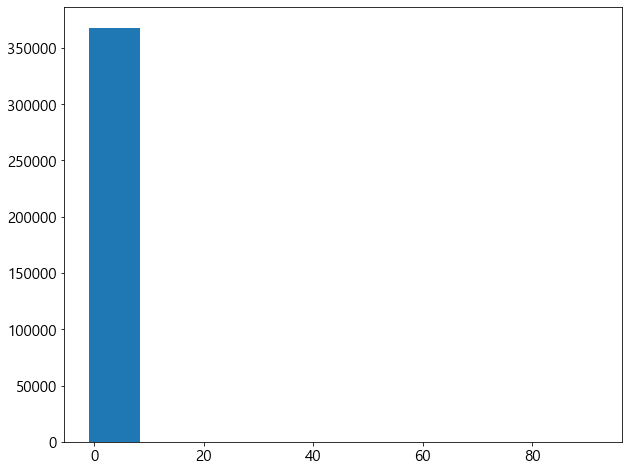

In [43]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='공급량비율', data=total)

(array([  95.,  598., 3719., 4980., 2608., 1781.,  961.,  310.,   47.,
          21.]),
 array([-0.27715136, -0.20448674, -0.13182212, -0.0591575 ,  0.01350712,
         0.08617174,  0.15883636,  0.23150098,  0.3041656 ,  0.37683022,
         0.44949484]),
 <BarContainer object of 10 artists>)

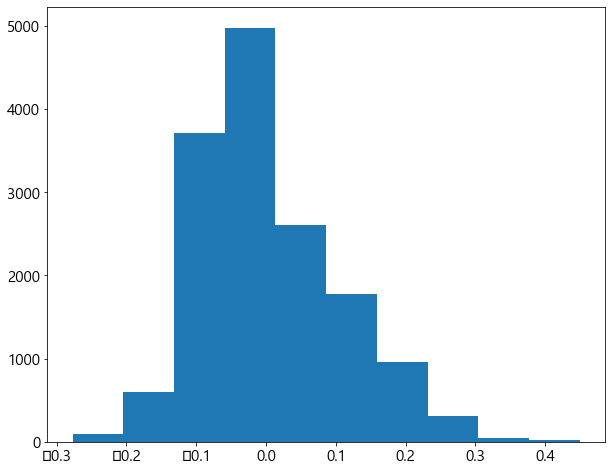

In [44]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='공급량비율', data=test2019)

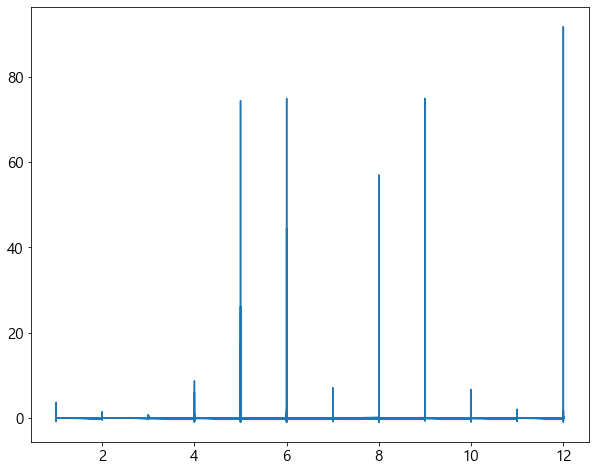

In [46]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot('month', '공급량비율', data=total)

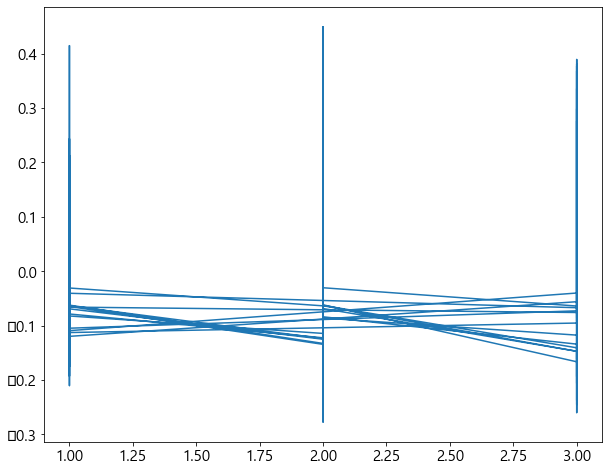

In [47]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot('month', '공급량비율', data=test2019)

{'whiskers': [<matplotlib.lines.Line2D at 0x1d61944f6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d61944fd60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d61944f340>],
 'medians': [<matplotlib.lines.Line2D at 0x1d619445d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d619091070>],
 'means': []}

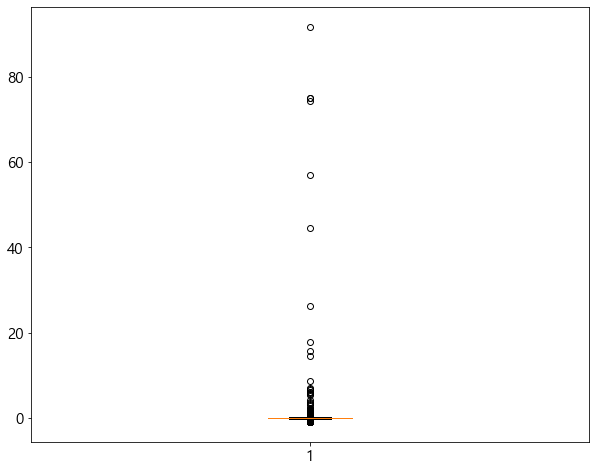

In [59]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.boxplot(x='공급량비율', data=total)

{'whiskers': [<matplotlib.lines.Line2D at 0x1d6199c3400>,
 'caps': [<matplotlib.lines.Line2D at 0x1d6199c3ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d6199c30a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1d6199b4e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d6199c3d90>],
 'means': []}

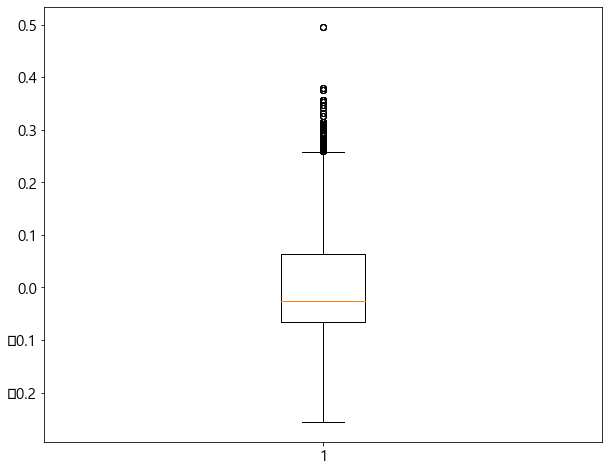

In [60]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.boxplot(x='공급량비율', data=test2019)

In [50]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,공급량비율,기온비율,습도비율,기압비율
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,0.000000,0.000000,0.000000,0.000000
1,2013,1,1,1,2,0,2363.265,-8.4,60.0,1009.4,-0.053607,-0.011765,0.052632,-0.000594
2,2013,1,1,1,3,0,2258.505,-8.1,58.0,1009.2,-0.044329,-0.035714,-0.033333,-0.000198
3,2013,1,1,1,4,0,2243.969,-8.2,58.0,1008.2,-0.006436,0.012346,0.000000,-0.000991
4,2013,1,1,1,5,0,2344.105,-8.2,61.0,1007.3,0.044625,-0.000000,0.051724,-0.000893


{'whiskers': [<matplotlib.lines.Line2D at 0x1b185143340>,
 'caps': [<matplotlib.lines.Line2D at 0x1b185143a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b18513cfa0>],
 'medians': [<matplotlib.lines.Line2D at 0x1b185135d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b185143c10>],
 'means': []}

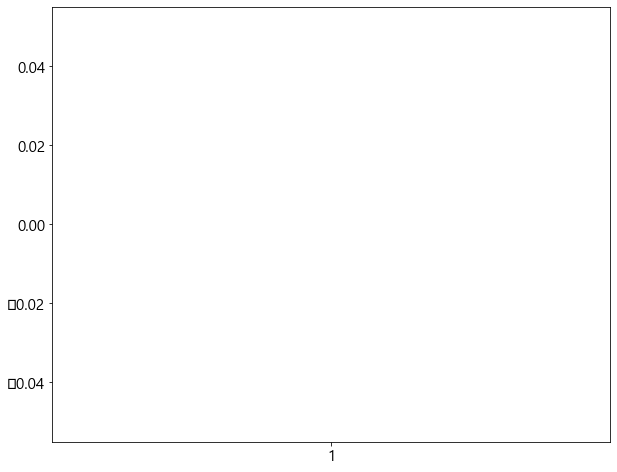

In [51]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.boxplot(x='기온비율', data=total)

{'whiskers': [<matplotlib.lines.Line2D at 0x1b1850d0820>,
 'caps': [<matplotlib.lines.Line2D at 0x1b1850c4850>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b1850d04c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1b1850d0af0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b1850d0e50>],
 'means': []}

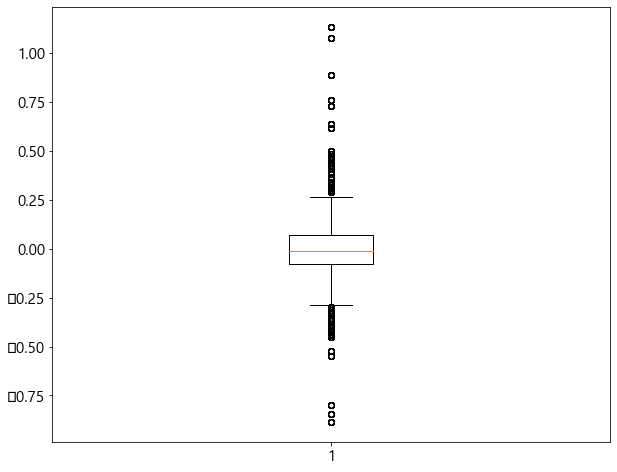

In [49]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.boxplot(x='기온비율', data=test2019)

{'whiskers': [<matplotlib.lines.Line2D at 0x1b1852f1400>,
 'caps': [<matplotlib.lines.Line2D at 0x1b1852e3df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b1852f10a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1b1852f1760>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b1852f1ac0>],
 'means': []}

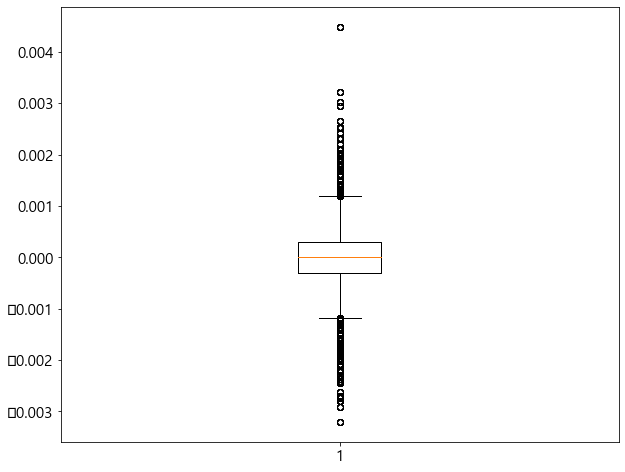

In [52]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.boxplot(x='기압비율', data=total)

{'whiskers': [<matplotlib.lines.Line2D at 0x1b18535a100>,
 'caps': [<matplotlib.lines.Line2D at 0x1b18534cb80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b185352d60>],
 'medians': [<matplotlib.lines.Line2D at 0x1b18535a460>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b18535a7c0>],
 'means': []}

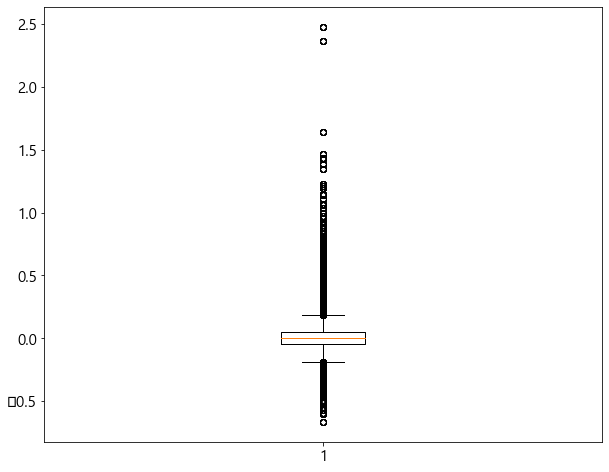

In [53]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.boxplot(x='습도비율', data=total)

<Figure size 864x576 with 0 Axes>

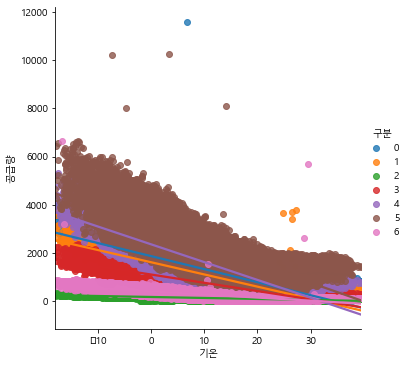

In [61]:
plt.figure(figsize=(12,8))
sns.lmplot(x='기온', y='공급량', hue='구분', data=total)

In [37]:
total.loc[368087,'공급량']

560.896

In [38]:
total.loc[368087, '공급량'] * 10

5608.959999999999

In [40]:
total.loc[(total['year']==2018) & (total['month']==12) & (total['day']==31) & (total['시간']==24), '공급량']

52583     2583.340
105167    2290.154
157751     237.911
210335    1422.478
262919    3534.260
315503    3982.757
368087     560.896
Name: 공급량, dtype: float64

In [41]:
total.iloc[-1,6]

560.896

In [42]:
total.iloc[-1,6] * 10

5608.959999999999

### 공급량비율로 공급량 구하기

In [44]:
# 전체 데이터에서 필요한 특성만 가져오기
train = total[['year', 'month', 'day', 'weekday', '시간', '구분', '공급량']]

# 구분에 따라 예측하기
divisions = test2019['구분'].unique()

total_gas = []
for division in tqdm(divisions):
    # 구분별 셋 설정
    temp_train = train[train['구분'] == division].reset_index(drop=True)
    temp_test = test2019[test2019['구분'] == division].reset_index(drop=True)

    # 2018년 12월 31일 24시 값
    one_div_gas = []
    temp_gas = temp_train.iloc[-1, 6]
    one_div_gas.append(temp_gas)
    
    # 해당일 공급량 = 전날 공급량 * ( 1 + 해당일 공급량 비율 )
    for i in range(len(temp_test['공급량비율'])):
        present_gas_rate = temp_test.loc[i, '공급량비율']
        present_gas = one_div_gas[-1] * ( 1 + present_gas_rate)
        one_div_gas.append(present_gas)
    
    # 첫번째 값은 2018년 12월 31일 24시 값이므로 제거
    one_div_gas.pop(0)

    # 구분 전체 가스공급량을 하나의 리스트에 저장
    total_gas += one_div_gas

100%|██████████| 7/7 [00:00<00:00, 20.75it/s]


In [45]:
# 총 15120개
len(total_gas)

15120

## 제출 파일 만들기

In [47]:
sub = pd.read_csv('../data/sample_submission.csv')
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [48]:
sub.tail()

,일자|시간|구분,공급량
15115,2019-03-31 20 H,0
15116,2019-03-31 21 H,0
15117,2019-03-31 22 H,0
15118,2019-03-31 23 H,0
15119,2019-03-31 24 H,0


In [49]:
sub['공급량'] = total_gas
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,2352.682383
1,2019-01-01 02 A,2041.490928
2,2019-01-01 03 A,1881.861443
3,2019-01-01 04 A,1932.579388
4,2019-01-01 05 A,2140.328256


In [52]:
sub.tail()

,일자|시간|구분,공급량
15115,2019-03-31 20 H,45.562802
15116,2019-03-31 21 H,46.523646
15117,2019-03-31 22 H,43.542370
15118,2019-03-31 23 H,39.489674
15119,2019-03-31 24 H,36.467242


In [50]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   일자|시간|구분  15120 non-null  object 
 1   공급량       15120 non-null  float64
dtypes: float64(1), object(1)
memory usage: 236.4+ KB


In [51]:
sub.to_csv("sub25_pycaret13.csv", index=False)